In [ ]:
import sys
import os
import random
import numpy as np
import pandas as pd
import torch

import torch.nn.functional as F
from torch import nn, utils, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import defaultdict
from itertools import chain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Подготовим и обработаем данные

In [ ]:
RANDOM_STATE = 27
BATCH_SIZE = 16
TRAIN_PROPORTION = 0.8
ROUND_ACCURACY = 15 

SIZE_128 = (128, 128)
SIZE_32 = (32, 32)

In [ ]:
torch.manual_seed(RANDOM_STATE)
random.seed = RANDOM_STATE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### IMAGE (128*128)

In [ ]:
data_transform_128 = transforms.Compose([transforms.Resize(SIZE_128),transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
full_dataset_128 = datasets.ImageFolder('drive/MyDrive/beat_cars/rps-cv-images/', data_transform_128)

train_size_128 = int(TRAIN_PROPORTION * len(full_dataset))
test_size_128 = len(full_dataset) - train_size 

train_dataset_128, test_dataset_128 = utils.data.random_split(full_dataset_128, [train_size_128, test_size_128])
train_loader_128, test_loader_128 = utils.data.DataLoader(train_dataset_128, batch_size=BATCH_SIZE, shuffle=True), utils.data.DataLoader(test_dataset_128, batch_size=BATCH_SIZE, shuffle=True)

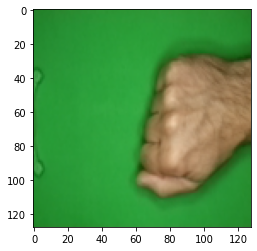

tensor(1)


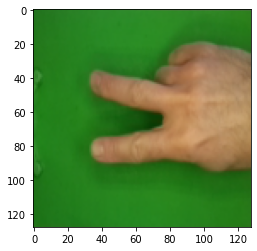

tensor(2)


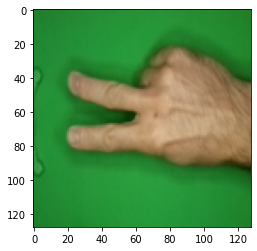

tensor(2)


In [ ]:
images_128, labels_128 = iter(train_loader_128).next()
for image_128, label_128 in zip(images_128[:3], labels_128[:3]):

    plt.imshow(np.transpose((image_128 / 2 + 0.5 ).numpy(), (1, 2, 0)))
    plt.show()
    print(label_128)

### IMAGE (32*32)

In [ ]:
data_transform_32 = transforms.Compose([transforms.Resize(SIZE_32),transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
full_dataset_32 = datasets.ImageFolder('drive/MyDrive/beat_cars/rps-cv-images/', data_transform_32)

train_size_32 = int(TRAIN_PROPORTION * len(full_dataset))
test_size_32 = len(full_dataset) - train_size 

train_dataset_32, test_dataset_32 = utils.data.random_split(full_dataset_32, [train_size_32, test_size_32])
train_loader_32, test_loader_32 = utils.data.DataLoader(train_dataset_32, batch_size=BATCH_SIZE, shuffle=True), utils.data.DataLoader(test_dataset_32, batch_size=BATCH_SIZE, shuffle=True)

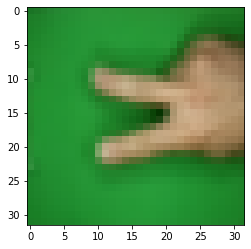

tensor(2)


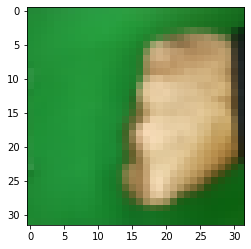

tensor(1)


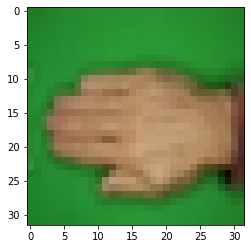

tensor(0)


In [ ]:
images_32, labels_32 = iter(train_loader_32).next()
for image_32, label_32 in zip(images_32[:3], labels_32[:3]):

    plt.imshow(np.transpose((image_32 / 2 + 0.5 ).numpy(), (1, 2, 0)))
    plt.show()
    print(label_32)

## Подготовим вспомогательные функции

In [ ]:
def train_and_test_model(device, train_loader, test_loader, model, epoch = 1):
    print("Started")

    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    accuracy_list = [] 

    for epoch in range(epoch): 
        epoch_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        round_loss = round(epoch_loss / len(train_loader), ROUND_ACCURACY)
        print(epoch + 1, "- Loss", round_loss)

        loss_list.append(round_loss)

        accuracy = test_model(device, test_loader, net, epoch + 1)
        accuracy_list.append(accuracy)
        
    torch.cuda.empty_cache()
    print("Finished")

    return accuracy_list, loss_list


In [ ]:
def test_model(device, loader, model, current_epoch):
    success, total = 0, 0

    with torch.no_grad():

        for images, labels in loader:
            device_images = images.to(device)
            device_labels = labels.to(device)
            outputs = model(device_images)

            _, predicted = torch.max(outputs.data, 1)

            total += device_labels.size(0)
            success += sum(list(map(lambda x: x.item(), (predicted == device_labels))))

    accuracy = round(success / total, ROUND_ACCURACY)
    print(current_epoch, "- Accuracy", accuracy)
    print("_____________________________________")

    return accuracy

In [ ]:
def show_nn_plot(loss_list, accuracy_list):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

    ax1.plot(loss_list, label='loss', color="red")
    ax1.grid()
    ax1.set_ylim([0, 1])
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')

    ax2.plot(accuracy_list, label='accuracy', color="green")
    ax2.legend()
    ax2.grid()
    ax2.set_ylim([0.5, 1])

## Натренируем нейронки

### Linear


In [ ]:
class NeuralNetwork_L4(nn.Module):
    
    def __init__(self, IMAGE_SIZE):
        super(NeuralNetwork_L4, self).__init__()
        self.IMAGE_SIZE = IMAGE_SIZE
        self.fc1 = nn.Linear(self.IMAGE_SIZE[0] * self.IMAGE_SIZE[1] * 3, 480)
        self.fc2 = nn.Linear(480, 120)
        self.fc3 = nn.Linear(120, 80)
        self.fc4 = nn.Linear(80, 3)

    def forward(self, x):
        x = x.view(-1, self.IMAGE_SIZE[0] * self.IMAGE_SIZE[1] * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
net = NeuralNetwork_L4(SIZE_128).to(device)
print(net)

NeuralNetwork_L4(
  (fc1): Linear(in_features=49152, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=3, bias=True)
)


In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_128, test_loader_128, net, 7)

Started
1 - Loss 0.758587026325139
1 - Accuracy 0.840182648401826
_____________________________________
2 - Loss 0.419348848543384
2 - Accuracy 0.924657534246575
_____________________________________
3 - Loss 0.244854790776629
3 - Accuracy 0.865296803652968
_____________________________________
4 - Loss 0.183995260442184
4 - Accuracy 0.942922374429224
_____________________________________
5 - Loss 0.137742598854344
5 - Accuracy 0.949771689497717
_____________________________________
6 - Loss 0.14729958108457
6 - Accuracy 0.874429223744292
_____________________________________
7 - Loss 0.101734197010625
7 - Accuracy 0.942922374429224
_____________________________________
Finished


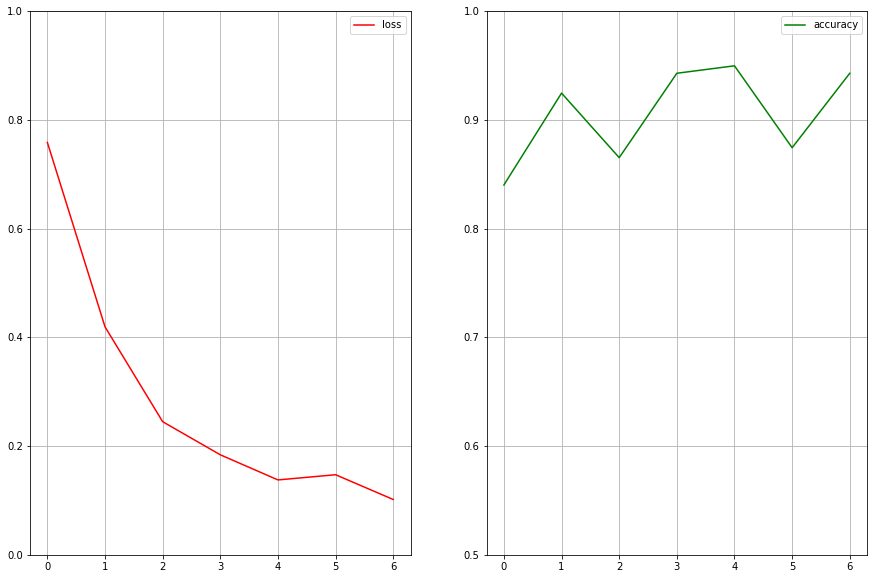

In [ ]:
show_nn_plot(loss_list, accuracy_list)

In [ ]:
net = NeuralNetwork_L4(SIZE_32).to(device)
print(net)

NeuralNetwork_L4(
  (fc1): Linear(in_features=3072, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=3, bias=True)
)


Started
1 - Loss 1.045465170795267
1 - Accuracy 0.680365296803653
_____________________________________
2 - Loss 0.611499496210705
2 - Accuracy 0.78310502283105
_____________________________________
3 - Loss 0.34367608577013
3 - Accuracy 0.885844748858447
_____________________________________
4 - Loss 0.225178724637424
4 - Accuracy 0.888127853881279
_____________________________________
5 - Loss 0.168950699684633
5 - Accuracy 0.952054794520548
_____________________________________
6 - Loss 0.182366957710209
6 - Accuracy 0.938356164383562
_____________________________________
7 - Loss 0.127958638204092
7 - Accuracy 0.952054794520548
_____________________________________
Finished


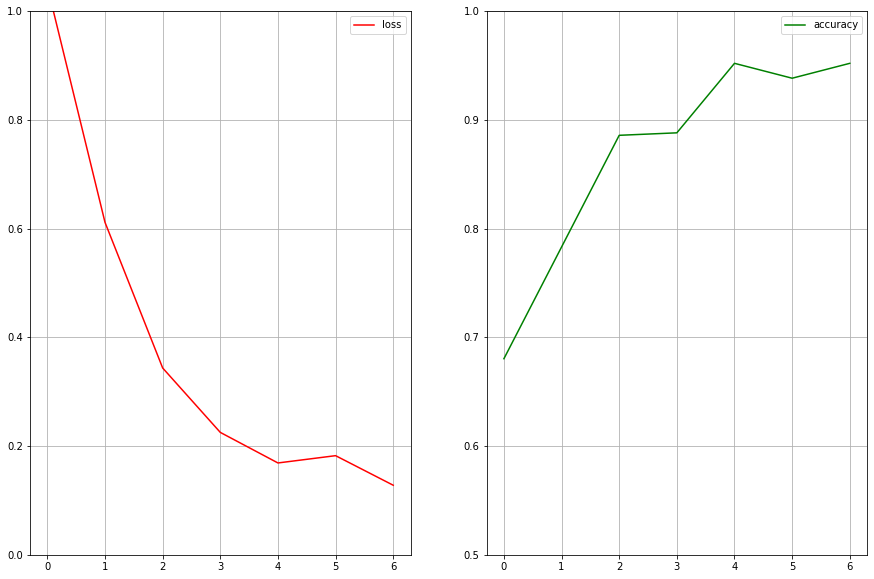

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_32, test_loader_32, net, 7)
show_nn_plot(loss_list, accuracy_list)

#####Более сильно сжатое фото(32 пикселя) показало по итогу немного более лучший результат, чем 128 пиксельное - 95% против 94%

### Один слой, мало каналов

Для 128*128

In [ ]:
class  NeuralNetwork_Layer1_128(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer1_128, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 6, kernel_size=7), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 

        self.linear_input_size = 61 * 61 * 6

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer1_128().to(device)
print(net)

NeuralNetwork_Layer1_128(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=22326, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.786026389490474
1 - Accuracy 0.883561643835616
_____________________________________
2 - Loss 0.344395944340663
2 - Accuracy 0.920091324200913
_____________________________________
3 - Loss 0.208431219114837
3 - Accuracy 0.874429223744292
_____________________________________
4 - Loss 0.137697154672986
4 - Accuracy 0.908675799086758
_____________________________________
5 - Loss 0.130696272147311
5 - Accuracy 0.917808219178082
_____________________________________
6 - Loss 0.103642125865868
6 - Accuracy 0.872146118721461
_____________________________________
7 - Loss 0.114285014607065
7 - Accuracy 0.929223744292237
_____________________________________
Finished


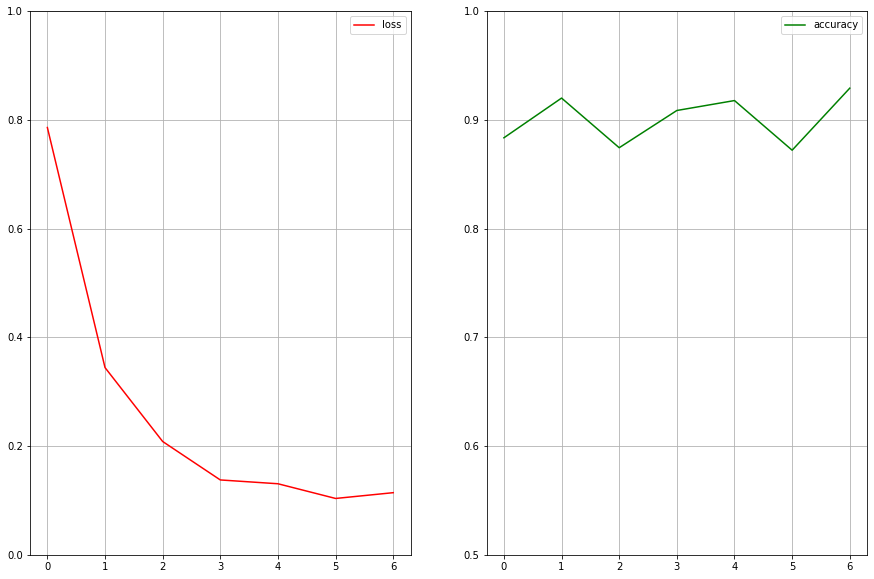

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_128, test_loader_128, net, 7)
show_nn_plot(loss_list, accuracy_list)

Для 32*32

In [ ]:
class  NeuralNetwork_Layer1_32(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer1_32, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 6, kernel_size=7), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 

        self.linear_input_size = 13 * 13 * 6

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer1_32().to(device)
print(net)

NeuralNetwork_Layer1_32(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1014, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.718574368140914
1 - Accuracy 0.892694063926941
_____________________________________
2 - Loss 0.243778248385272
2 - Accuracy 0.940639269406393
_____________________________________
3 - Loss 0.131650388145565
3 - Accuracy 0.95662100456621
_____________________________________
4 - Loss 0.086398866812868
4 - Accuracy 0.970319634703196
_____________________________________
5 - Loss 0.057983768552499
5 - Accuracy 0.947488584474886
_____________________________________
6 - Loss 0.042597003598084
6 - Accuracy 0.977168949771689
_____________________________________
7 - Loss 0.033575931185624
7 - Accuracy 0.977168949771689
_____________________________________
Finished


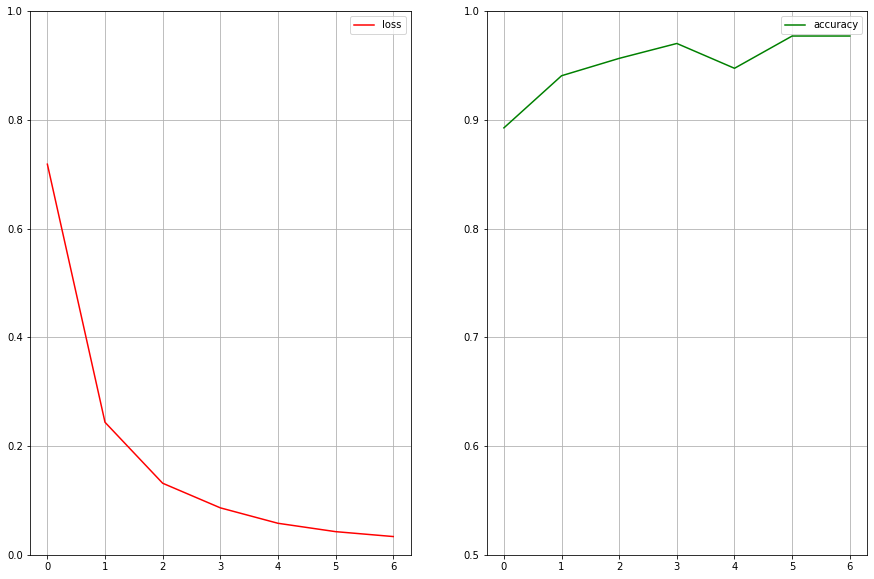

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_32, test_loader_32, net, 7)
show_nn_plot(loss_list, accuracy_list)

#####Нейронная сеть со сверточными слоями и использованием max пулинга показала результат значительно хуже(92%) на 128 пиксельных картинках. Зато на 32 пикселях произошло заметное улучшение до 97%
#####Для вычисления выходящего размера мы использовали формулу
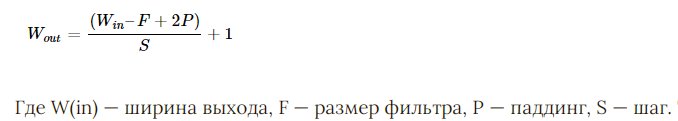

### Один слой, много каналов

In [ ]:
class NeuralNetwork_Layer1_Channel32_128(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer1_Channel32_128, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=7, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 

        # (w - K + 2P) / S) + 1
        self.linear_input_size = 61 * 61 * 32

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer1_Channel32_128().to(device)
print(net)

NeuralNetwork_Layer1_Channel32_128(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=119072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.782382847910578
1 - Accuracy 0.828767123287671
_____________________________________
2 - Loss 0.352713267149573
2 - Accuracy 0.908675799086758
_____________________________________
3 - Loss 0.19704234120436
3 - Accuracy 0.954337899543379
_____________________________________
4 - Loss 0.086107742750954
4 - Accuracy 0.954337899543379
_____________________________________
5 - Loss 0.080780131204202
5 - Accuracy 0.926940639269406
_____________________________________
6 - Loss 0.053621086322396
6 - Accuracy 0.949771689497717
_____________________________________
7 - Loss 0.11370169702621
7 - Accuracy 0.91324200913242
_____________________________________
Finished


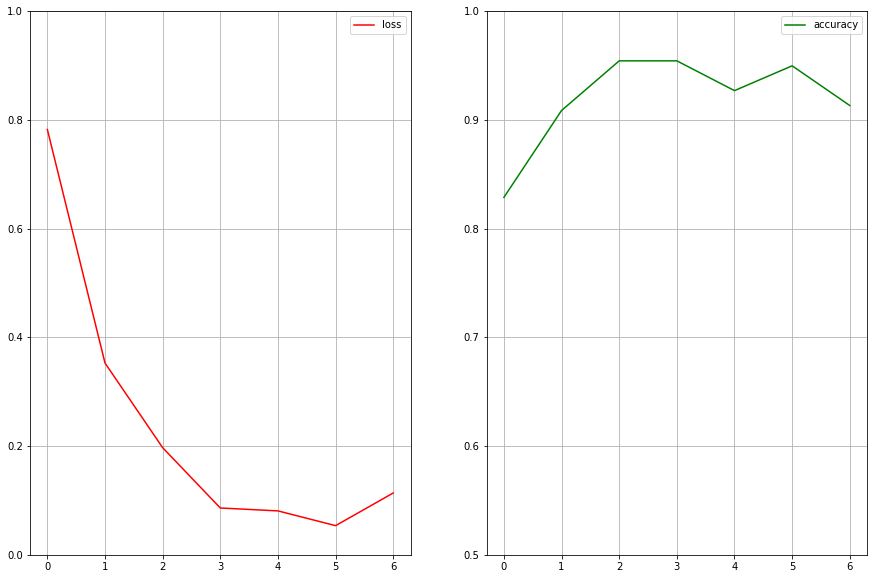

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_128, test_loader_128, net, 7)
show_nn_plot(loss_list, accuracy_list)

In [ ]:
class NeuralNetwork_Layer1_Channel32_32(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer1_Channel32_32, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=7, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 

        # (w - K + 2P) / S) + 1
        self.linear_input_size = 13 * 13 * 32

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = out.reshape(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer1_Channel32_32().to(device)
print(net)

NeuralNetwork_Layer1_Channel32_32(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=5408, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.562071122229099
1 - Accuracy 0.929223744292237
_____________________________________
2 - Loss 0.158662424609065
2 - Accuracy 0.952054794520548
_____________________________________
3 - Loss 0.095314696215262
3 - Accuracy 0.947488584474886
_____________________________________
4 - Loss 0.065521323134784
4 - Accuracy 0.963470319634703
_____________________________________
5 - Loss 0.058136981990273
5 - Accuracy 0.968036529680365
_____________________________________
6 - Loss 0.033966023021474
6 - Accuracy 0.977168949771689
_____________________________________
7 - Loss 0.024876999335406
7 - Accuracy 0.979452054794521
_____________________________________
Finished


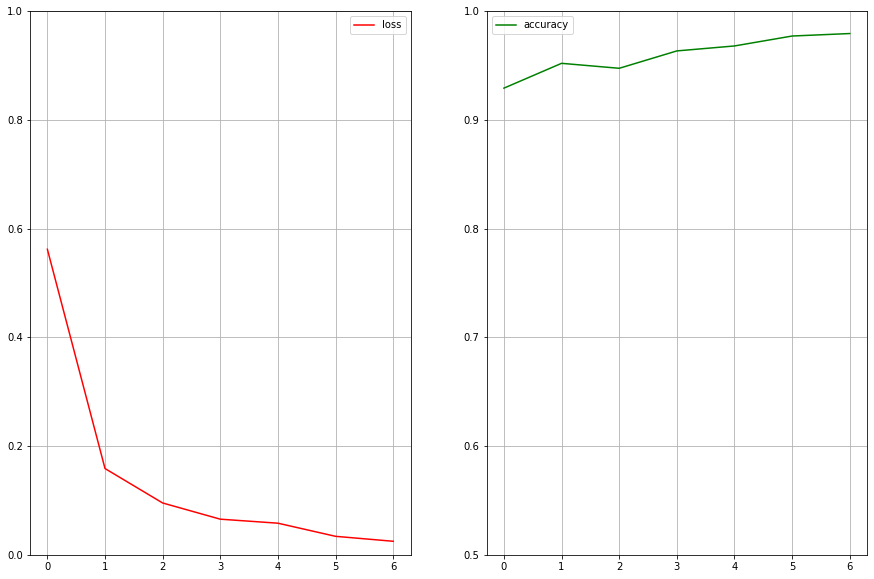

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_32, test_loader_32, net, 7)
show_nn_plot(loss_list, accuracy_list)

При увеличении количества каналов на 128 пикселях ошибка перестала падать, а значит не имеет смысла дальше обучать модель. Точность варьировалась от 91 до 95. На 32 же большое количество каналов не привело к такому событию, и даже еще улучшило точность до почти 98%.


### Один слой + drop out

In [ ]:
class NeuralNetwork_Layer1_Drop_128(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer1_Drop_128, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=7, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 
        self.drop_out = nn.Dropout() 

        # (w - K + 2P) / S) + 1
        self.linear_input_size = 61 * 61 * 32

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer1_Drop_128().to(device)
print(net)

NeuralNetwork_Layer1_Drop_128(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=119072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.563934220712293
1 - Accuracy 0.924657534246575
_____________________________________
2 - Loss 0.317942902902988
2 - Accuracy 0.938356164383562
_____________________________________
3 - Loss 0.155666155550121
3 - Accuracy 0.929223744292237
_____________________________________
4 - Loss 0.109113239667336
4 - Accuracy 0.961187214611872
_____________________________________
5 - Loss 0.130387837063013
5 - Accuracy 0.965753424657534
_____________________________________
6 - Loss 0.059685412137002
6 - Accuracy 0.954337899543379
_____________________________________
7 - Loss 0.101842484629808
7 - Accuracy 0.949771689497717
_____________________________________
Finished


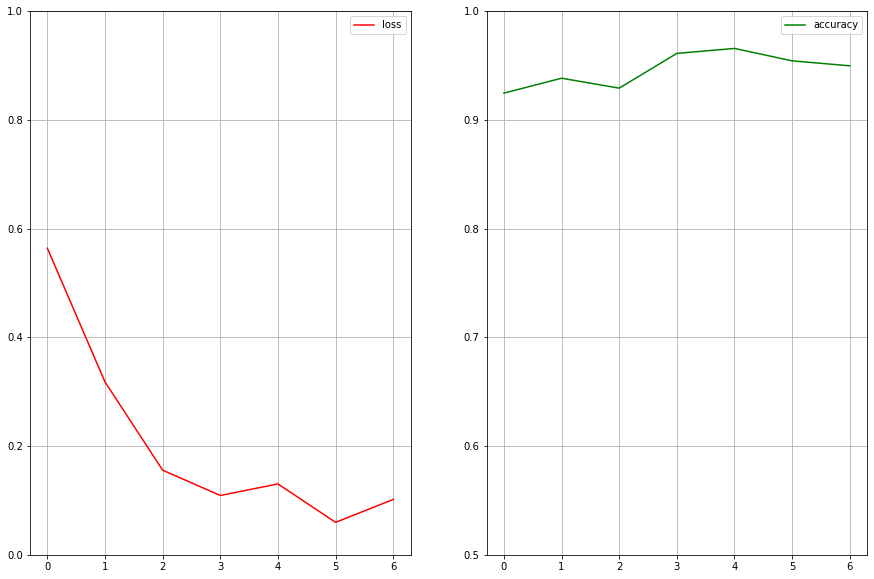

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_128, test_loader_128, net, 7)
show_nn_plot(loss_list, accuracy_list)

In [ ]:
class NeuralNetwork_Layer1_Drop_32(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer1_Drop_32, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=7, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 
        self.drop_out = nn.Dropout() 

        # (w - K + 2P) / S) + 1
        self.linear_input_size = 13 * 13 * 32

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer1_Drop_32().to(device)
print(net)

NeuralNetwork_Layer1_Drop_32(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5408, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.584172747487372
1 - Accuracy 0.9337899543379
_____________________________________
2 - Loss 0.194560213920406
2 - Accuracy 0.942922374429224
_____________________________________
3 - Loss 0.102950705185702
3 - Accuracy 0.949771689497717
_____________________________________
4 - Loss 0.099379634865644
4 - Accuracy 0.954337899543379
_____________________________________
5 - Loss 0.062835922556802
5 - Accuracy 0.970319634703196
_____________________________________
6 - Loss 0.052046139080564
6 - Accuracy 0.968036529680365
_____________________________________
7 - Loss 0.035574697887006
7 - Accuracy 0.970319634703196
_____________________________________
Finished


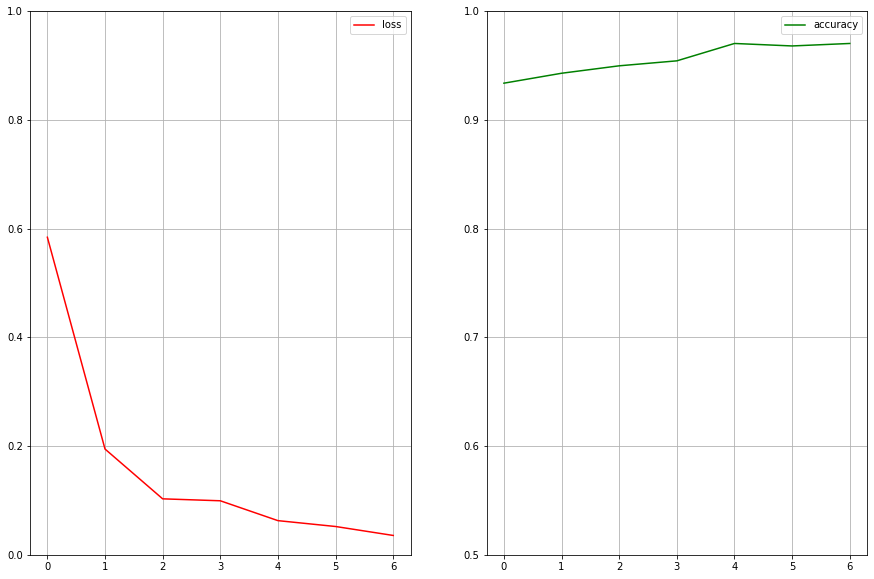

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_32, test_loader_32, net, 7)
show_nn_plot(loss_list, accuracy_list)

Dropout немного улучшил результаты для 128 пикселей, но у них осталась та же проблема с ошибками. Для 32 модель все еще стабильна, но точность упала до 97%

### Два слоя с drop out или без

In [ ]:
class NeuralNetwork_Layer2_Drop_128(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer2_Drop_128, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=7, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 
        
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=7), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 

        # (w - K + 2P) / S) + 1
        self.linear_input_size = 27 * 27 * 64

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer2_Drop_128().to(device)
print(net)

NeuralNetwork_Layer2_Drop_128(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=46656, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.548119862513109
1 - Accuracy 0.936073059360731
_____________________________________
2 - Loss 0.183283736870031
2 - Accuracy 0.95662100456621
_____________________________________
3 - Loss 0.084282367042827
3 - Accuracy 0.972602739726027
_____________________________________
4 - Loss 0.072681797545573
4 - Accuracy 0.977168949771689
_____________________________________
5 - Loss 0.025515255291909
5 - Accuracy 0.986301369863014
_____________________________________
6 - Loss 0.062018580781693
6 - Accuracy 0.993150684931507
_____________________________________
7 - Loss 0.01892539680085
7 - Accuracy 0.979452054794521
_____________________________________
Finished


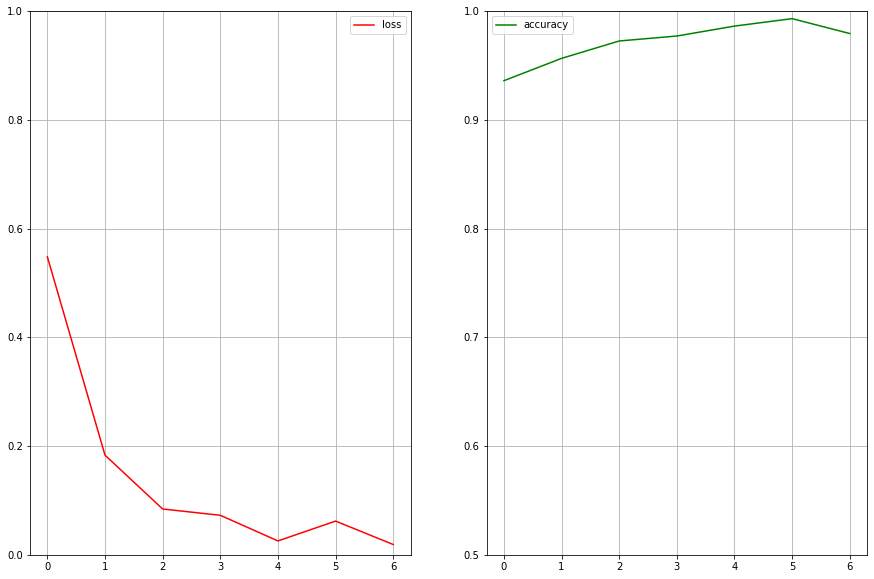

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_128, test_loader_128, net, 7)
show_nn_plot(loss_list, accuracy_list)

In [ ]:
class NeuralNetwork_Layer2_128(nn.Module): 
    def __init__(self): 
        super(NeuralNetwork_Layer2_128, self).__init__() 

        self.layer1 = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=7, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
            ) 
        
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=7), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        # self.drop_out = nn.Dropout() 

        # (w - K + 2P) / S) + 1
        self.linear_input_size = 27 * 27 * 64

        self.fc1 = nn.Linear(self.linear_input_size, 1000) 
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        # out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

net = NeuralNetwork_Layer2_128().to(device)
print(net)

NeuralNetwork_Layer2_128(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=46656, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)


Started
1 - Loss 0.605498967421326
1 - Accuracy 0.947488584474886
_____________________________________
2 - Loss 0.229771066435867
2 - Accuracy 0.972602739726027
_____________________________________
3 - Loss 0.116039222164281
3 - Accuracy 0.9337899543379
_____________________________________
4 - Loss 0.065221106596503
4 - Accuracy 0.972602739726027
_____________________________________
5 - Loss 0.048674428767514
5 - Accuracy 0.990867579908676
_____________________________________
6 - Loss 0.045475560395392
6 - Accuracy 0.981735159817352
_____________________________________
7 - Loss 0.061119680616784
7 - Accuracy 0.968036529680365
_____________________________________
Finished


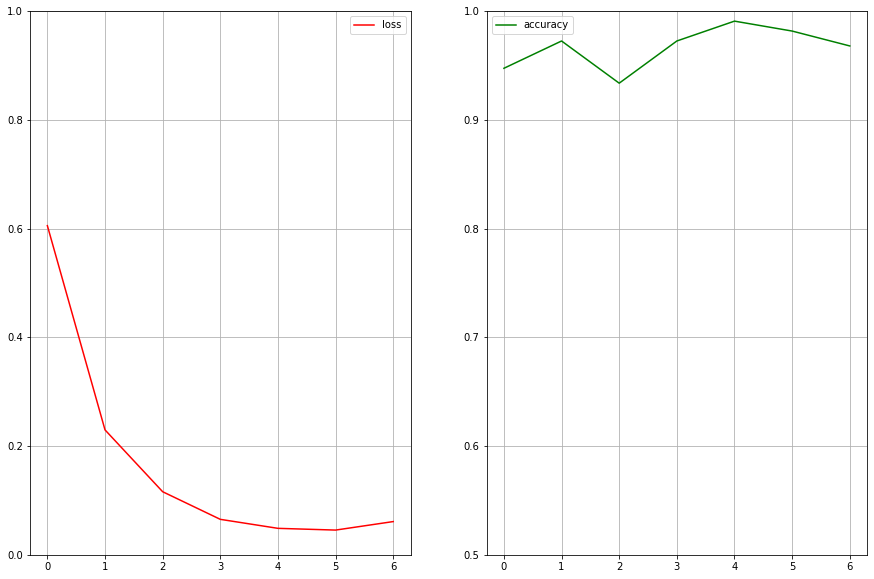

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_128, test_loader_128, net, 7)
show_nn_plot(loss_list, accuracy_list)

На двух слоях в обоих случаях удалось достигнуть 99% точности. Этот пик приходился на 5-6 эпохи и дальнейшее обучение не давало улучшение точности из-за нехватки тренировочных данных

### Flatten Linear

In [ ]:
class NeuralNetwork_FlattenLinear(nn.Module):

  def __init__(self, IMAGE_SIZE):
    super(NeuralNetwork_FlattenLinear, self).__init__()
    self.IMAGE_SIZE = IMAGE_SIZE
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(self.IMAGE_SIZE[0] * self.IMAGE_SIZE[1] * 3, 480),
      nn.ReLU(),
      nn.Linear(480, 80),
      nn.ReLU(),
      nn.Linear(80, 3)
    )

  def forward(self, x):
    return self.layers(x)


net = NeuralNetwork_FlattenLinear(SIZE_128).to(device)
print(net)

NeuralNetwork_FlattenLinear(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49152, out_features=480, bias=True)
    (2): ReLU()
    (3): Linear(in_features=480, out_features=80, bias=True)
    (4): ReLU()
    (5): Linear(in_features=80, out_features=3, bias=True)
  )
)


Started
1 - Loss 0.657636611434546
1 - Accuracy 0.824200913242009
_____________________________________
2 - Loss 0.362490616332401
2 - Accuracy 0.833333333333333
_____________________________________
3 - Loss 0.286640910888937
3 - Accuracy 0.867579908675799
_____________________________________
4 - Loss 0.148242417436135
4 - Accuracy 0.961187214611872
_____________________________________
5 - Loss 0.134496203194034
5 - Accuracy 0.940639269406393
_____________________________________
6 - Loss 0.136274448858405
6 - Accuracy 0.961187214611872
_____________________________________
7 - Loss 0.106452864451884
7 - Accuracy 0.947488584474886
_____________________________________
Finished


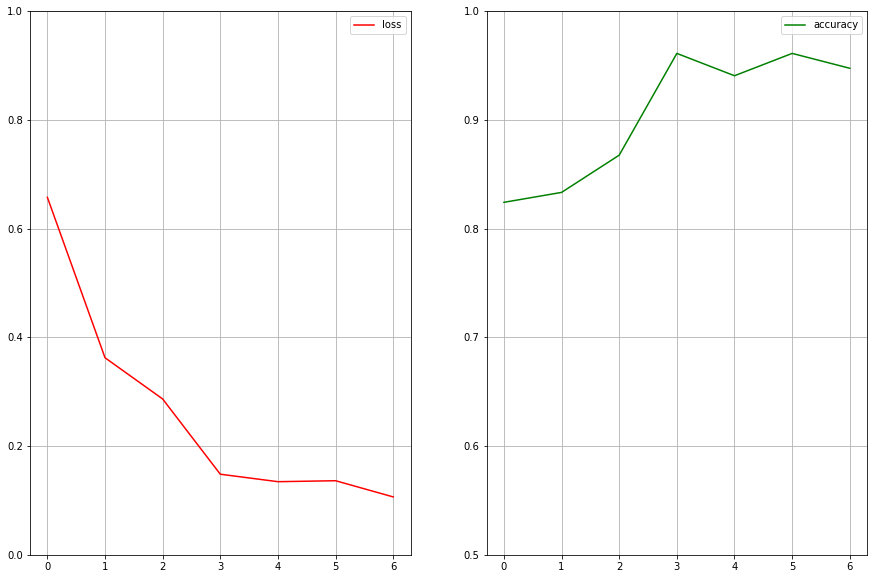

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_128, test_loader_128, net, 7)
show_nn_plot(loss_list, accuracy_list)

In [ ]:
net = NeuralNetwork_FlattenLinear(SIZE_32).to(device)
print(net)

NeuralNetwork_FlattenLinear(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=480, bias=True)
    (2): ReLU()
    (3): Linear(in_features=480, out_features=80, bias=True)
    (4): ReLU()
    (5): Linear(in_features=80, out_features=3, bias=True)
  )
)


Started
1 - Loss 0.794790796800093
1 - Accuracy 0.819634703196347
_____________________________________
2 - Loss 0.436140419949185
2 - Accuracy 0.865296803652968
_____________________________________
3 - Loss 0.232419982586395
3 - Accuracy 0.936073059360731
_____________________________________
4 - Loss 0.1843050934713
4 - Accuracy 0.952054794520548
_____________________________________
5 - Loss 0.147741928806698
5 - Accuracy 0.949771689497717
_____________________________________
6 - Loss 0.116038951330649
6 - Accuracy 0.949771689497717
_____________________________________
7 - Loss 0.098432160384784
7 - Accuracy 0.952054794520548
_____________________________________
Finished


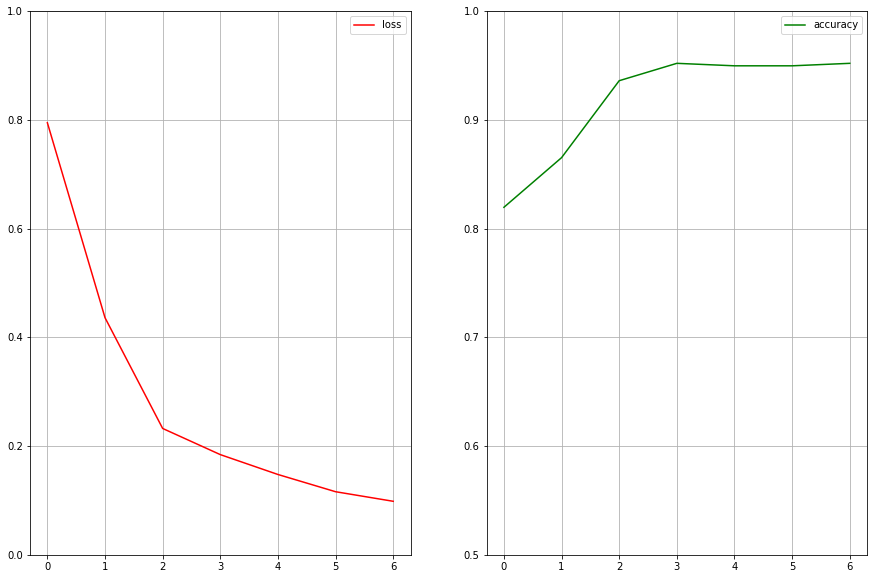

In [ ]:
accuracy_list, loss_list = train_and_test_model(device, train_loader_32, test_loader_32, net, 7)
show_nn_plot(loss_list, accuracy_list)

С использованием Flatten результаты достигали в пике 95-96%, но в последующие эпохи улучшения точности не происходило, что опять же говорит о небольшой выборке.

#####По итогу можно сделать вывод, что модели заметно лучше работают с картинками более низкого качества (32 пикселя). Наивысшую точность показали варианты:
##### - Один слой и много каналов
##### - Два слоя